# Forecasting CO₂ Emissions (SDG 13)

This notebook fetches **real data from the World Bank API** for CO₂ emissions (metric tons per capita) and
renewable energy consumption (% of total final energy consumption). It demonstrates EDA, a simple
feature engineering step, a Random Forest regression baseline, evaluation, and plots.

Run each cell in order. The notebook is intentionally single-file and uses only libraries you already
have installed (`requests`, `pandas`, `numpy`, `matplotlib`, `seaborn`, `scikit-learn`, `joblib`).


In [4]:
# Imports
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import joblib
import os

sns.set(style='whitegrid')


In [20]:
# Parameters
COUNTRIES = {
    'KEN': 'Kenya',
    'USA': 'United States',
    'CHN': 'China',
    'DEU': 'Germany',
    'IND': 'India'
}
INDICATORS = {
    'EN.ATM.CO2E.KT': 'CO2 emissions (kt)',       # metric tons per capita
    'EG.FEC.RNEW.ZS': 'Renewable_pct'        # % of total final energy consumption
}
START_YEAR = 2010
END_YEAR = 2022

OUT_DIR = 'outputs'
os.makedirs(OUT_DIR, exist_ok=True)


In [28]:
def fetch_indicator(country_code, indicator_code, start_year=START_YEAR, end_year=END_YEAR):
    """Fetch time series for a single indicator + country from World Bank API.
    Returns a DataFrame with columns ['countryiso3code','country','date','value','indicator']
    """
    url = (
        f'https://api.worldbank.org/v2/country/{country_code}/indicator/{indicator_code}'
        f'?date={start_year}:{end_year}&format=json&per_page=1000'
    )
    r = requests.get(url)
    if r.status_code != 200:
        raise RuntimeError(f'World Bank API request failed: {r.status_code} for {url}')
    data = r.json()
    # data[1] is the list of records
    if not isinstance(data, list) or len(data) < 2:
        return pd.DataFrame()
    records = data[1]
    df = pd.DataFrame(records)
    if df.empty:
        return df
    df = df[['countryiso3code','country','date','value']]
    df['indicator'] = indicator_code
    return df

# fetch for all countries and indicators
frames = []
for c in COUNTRIES.keys():
    for ind_code in INDICATORS.keys():
        print(f'Fetching {ind_code} for {c}...')
        df_sub = fetch_indicator(c, ind_code)
        if not df_sub.empty:
            frames.append(df_sub)

if not frames:
    raise RuntimeError('No data fetched. Check internet connection or World Bank API availability.')

#print(frames)
raw = pd.concat(frames, ignore_index=True)
raw['date'] = raw['date'].astype(int)
raw = raw.rename(columns={'countryiso3code':'iso3'})

Fetching EN.ATM.CO2E.KT for KEN...
Fetching EG.FEC.RNEW.ZS for KEN...
Fetching EN.ATM.CO2E.KT for USA...
Fetching EG.FEC.RNEW.ZS for USA...
Fetching EN.ATM.CO2E.KT for CHN...
Fetching EG.FEC.RNEW.ZS for CHN...
Fetching EN.ATM.CO2E.KT for DEU...
Fetching EG.FEC.RNEW.ZS for DEU...
Fetching EN.ATM.CO2E.KT for IND...
Fetching EG.FEC.RNEW.ZS for IND...


In [29]:
for col in ['iso3', 'country', 'date', 'indicator', 'value']:
    bad = raw[col].apply(lambda x: isinstance(x, dict)).sum()
    print(f"{col}: {bad} dict entries")


iso3: 0 dict entries
country: 65 dict entries
date: 0 dict entries
indicator: 0 dict entries
value: 0 dict entries


In [30]:
raw['country'] = raw['country'].apply(
    lambda x: x.get('value') if isinstance(x, dict) else x
)


In [31]:
# ✅ Pivot so that each indicator becomes a column
final_df = (
    raw.pivot_table(
        index=['iso3', 'country', 'date'],
        columns='indicator',
        values='value'
    )
    .reset_index()
)

# ✅ Rename columns for readability
final_df = final_df.rename(columns=INDICATORS)

# ✅ Optional: sort nicely
final_df = final_df.sort_values(by=['country', 'date']).reset_index(drop=True)

print(final_df.head())
#raw.head()

indicator iso3 country  date  Renewable_pct
0          CHN   China  2010           12.3
1          CHN   China  2011           11.3
2          CHN   China  2012           11.5
3          CHN   China  2013           11.5
4          CHN   China  2014           11.9


In [32]:
print(df.columns.tolist())
missing = [col for col in INDICATORS.values() if col not in df.columns]
print("Missing columns:", missing)
available_cols = [c for c in ['iso3', 'country', 'date'] + list(INDICATORS.values()) if c in df.columns]
df = df[available_cols]


['iso3', 'country', 'date', 'Renewable_pct']
Missing columns: ['CO2 emissions (kt)']


In [25]:
# Pivot to wide format so each row = country + year, columns = indicators
df = raw.pivot_table(index=['iso3','country','date'], columns='indicator', values='value').reset_index()
df = df.rename(columns=INDICATORS)
available_cols = [c for c in ['iso3', 'country', 'date'] + list(INDICATORS.values()) if c in df.columns]
df = df[available_cols]
"""
df = df[['iso3','country','date'] + list(INDICATORS.values())]
"""
print('Rows before dropna:', len(df))
df = df.sort_values(['iso3','date'])
#df = df.dropna(subset=['CO2_per_capita'])  # require target
print('Rows after dropping missing target:', len(df))
df.head()


Rows before dropna: 60
Rows after dropping missing target: 60


indicator,iso3,country,date,Renewable_pct
0,CHN,China,2010,12.3
1,CHN,China,2011,11.3
2,CHN,China,2012,11.5
3,CHN,China,2013,11.5
4,CHN,China,2014,11.9


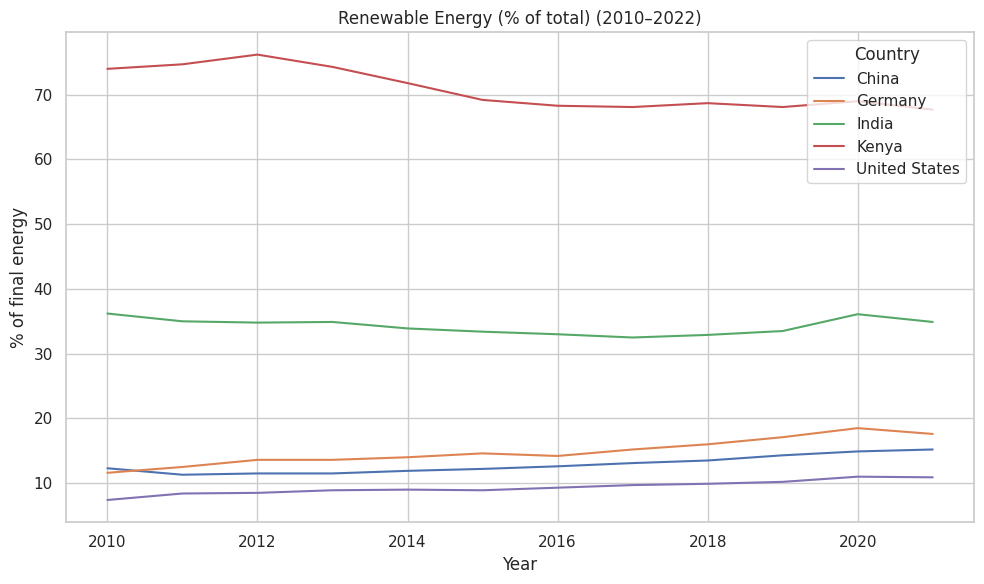

In [34]:
# Basic EDA plots
"""
plt.figure(figsize=(10,6))
#sns.lineplot(data=df, x='date', y='CO2 emissions (metric tons per capita)', hue='country')
sns.lineplot(data=df, x='date', y='CO2 emissions (kt)', hue='country')
plt.title('CO₂ Emissions per Capita (2010–2022)')
plt.ylabel('Metric Tons per Capita')
plt.xlabel('Year')
plt.legend(title='Country')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,'co2_timeseries.png'))
plt.show()

"""
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x='date', y='Renewable_pct', hue='country')
plt.title('Renewable Energy (% of total) (2010–2022)')
plt.ylabel('% of final energy')
plt.xlabel('Year')
plt.legend(title='Country')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,'renewable_timeseries.png'))
plt.show()

In [37]:
# Feature engineering: create lag features for CO2 and fill NA
#df['CO2_lag1'] = df.groupby('iso3')['CO2_per_capita'].shift(1)
#df['CO2_lag2'] = df.groupby('iso3')['CO2_per_capita'].shift(2)
df['Renewable_pct'] = df['Renewable_pct'].fillna(method='ffill')
#df = df.dropna(subset=['CO2_lag1'])  # require at least one lag
print('Rows after feature engineering:', len(df))
df.head()


Rows after feature engineering: 60


indicator,iso3,country,date,Renewable_pct
0,CHN,China,2010,12.3
1,CHN,China,2011,11.3
2,CHN,China,2012,11.5
3,CHN,China,2013,11.5
4,CHN,China,2014,11.9


In [ ]:
# Prepare data for modeling
features = ['CO2_lag1','CO2_lag2','Renewable_pct']
X = df[features].values
y = df['CO2_per_capita'].values

# train-test split (random by rows is acceptable here but we also keep country as grouping for later use)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f'MAE: {mae:.4f} | RMSE: {rmse:.4f} | R2: {r2:.4f}')

# Save model and processed data sample
joblib.dump(model, os.path.join(OUT_DIR,'rf_co2_model.joblib'))
df.to_csv(os.path.join(OUT_DIR,'co2_renewables_processed.csv'), index=False)
print('Saved model and processed CSV to', OUT_DIR)


In [ ]:
# Feature importance plot
fi = pd.Series(model.feature_importances_, index=features).sort_values(ascending=True)
plt.figure(figsize=(6,4))
fi.plot(kind='barh')
plt.title('Feature importances')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,'feature_importances.png'))
plt.show()


## Ethical reflection

- **Data quality & bias:** World Bank data coverage varies by country; low-income countries may have missing or low-quality reporting, which biases the model.
- **Use-case limitations:** Forecasts are not perfect and should be used as guidance, not as sole policy drivers.
- **Mitigations:** Stratified evaluation by income-group, transparent documentation, and involving domain experts in decision-making.
